In [9]:
import json
from collections import defaultdict
import shunting_yard

In [14]:
epsilon = "\u03B5"
alphanumerics = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

class State:
    def __init__(self,name):
        self.name = name
        self.in_edges = []
        self.out_edges = []

class Edge:
    def __init__(self, label:str ,dest:State):
        self.label = label
        self.dest = dest

class NFA:
    def __init__(self, char: str, start: State, accepting: State):
        self.states = [start,accepting]
        self.start = start
        self.accepting = accepting

        # edge = Edge(char,self.accepting)
        # self.start.out_edges.append(edge)
        # self.accepting.in_edges.append(edge)

    @staticmethod
    def postfix2NFA(postfix:str):
        stack = []
        state_counter= 1

        for char in postfix:
            if char=='.':
                nfa2 = stack.pop()
                nfa1 = stack.pop()

                edge = Edge(epsilon,nfa2.start)
                nfa1.accepting.out_edges.append(edge)
                nfa2.start.in_edges.append(edge)

                concatenated_nfa = NFA(epsilon, nfa1.start, nfa2.accepting)

                concatenated_nfa.states = nfa1.states + nfa2.states
                stack.append(concatenated_nfa)

            elif char=='|':
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3,edge4 = Edge(epsilon,nfa1.start),Edge(epsilon,nfa2.start),Edge(epsilon,new_accept),Edge(epsilon,new_accept)

                new_start.out_edges.append(edge1)
                nfa1.start.in_edges.append(edge1)

                new_start.out_edges.append(edge2)
                nfa2.start.in_edges.append(edge2)

                nfa1.accepting.out_edges.append(edge3)
                new_accept.in_edges.append(edge3)

                nfa2.accepting.out_edges.append(edge4)
                new_accept.in_edges.append(edge4)

                ored_nfa= NFA(epsilon, new_start, new_accept)

                ored_nfa.states = [new_start, new_accept] + nfa1.states + nfa2.states
                stack.append(ored_nfa)

            elif char=='*':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3,edge4 = Edge(epsilon,nfa.start),Edge(epsilon,new_accept),Edge(epsilon,new_start),Edge(epsilon,new_accept)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                nfa.accepting.out_edges.append(edge3)
                new_start.in_edges.append(edge3)

                new_start.out_edges.append(edge4)
                new_accept.in_edges.append(edge4)

                zero_or_more_nfa = NFA(epsilon, new_start, new_accept)
                zero_or_more_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(zero_or_more_nfa)

            elif char=='+':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3 = Edge(epsilon,nfa.start),Edge(epsilon,new_accept),Edge(epsilon,new_start)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                nfa.accepting.out_edges.append(edge3)
                new_start.in_edges.append(edge3)

                one_or_more_nfa = NFA(epsilon, new_start, new_accept)
                one_or_more_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(one_or_more_nfa)

            elif char == '?':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3 = Edge(epsilon,nfa.start),Edge(epsilon,new_accept),Edge(epsilon,new_accept)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                new_start.out_edges.append(edge3)
                new_accept.in_edges.append(edge3)

                zero_or_one_nfa = NFA(epsilon, new_start, new_accept)
                zero_or_one_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(zero_or_one_nfa)

            elif char in alphanumerics:
                start_state = State('S' + str(state_counter))
                accept_state = State('S' +  str(state_counter +1))
                state_counter += 2

                edge = Edge(char,accept_state)

                start_state.out_edges.append(edge)
                accept_state.in_edges.append(edge)

                single_char_nfa = NFA(char, start_state, accept_state)
                single_char_nfa.states.extend([start_state,accept_state])

                stack.append(single_char_nfa)

        return stack.pop()

    def to_json(self):
        nfa_dict = {"startingState": self.start.name}

        for state in self.states:
            state_info = {"isTerminatingState": state == self.accepting}
            # edge_dict = {}
            for edge in state.out_edges:
                destination = edge.dest

                if edge.label in state_info:
                  # if destination.name not in edge_dict[edge.label]:
                    # edge_dict[edge.label].append(destination.name)
                   state_info[edge.label] = list(state_info[edge.label]) + [destination.name]
                else:
                    state_info[edge.label] = [destination.name]

            # for label, destinations in edge_dict.items():
            #     state_info[label] = destinations

            nfa_dict[state.name] = state_info

        with open("NFA.json", "w") as json_file:
            json.dump(nfa_dict, json_file, indent=4, ensure_ascii=False)

        return nfa_dict


In [15]:
postfix = shunting_yard.infix2postfix('a+b')
# nfa = NFA.postfix2NFA(postfix='A+B*.?CD|.')
# nfa = NFA.postfix2NFA(postfix='ab|c|d|e|fA.|B|C|')
nfa = NFA.postfix2NFA(postfix)
# nfa = NFA.postfix2NFA(postfix='ab|c|d|e|f0.|1|2|3|4|5|6|7|8|9|3.2.')
nfa.to_json()

{'startingState': 'S3',
 'S3': {'isTerminatingState': False, 'ε': ['S1']},
 'S4': {'isTerminatingState': False, 'ε': ['S5']},
 'S1': {'isTerminatingState': False, 'a': ['S2']},
 'S2': {'isTerminatingState': False, 'ε': ['S4', 'S3']},
 'S5': {'isTerminatingState': False, 'b': ['S6']},
 'S6': {'isTerminatingState': True}}

In [16]:
from graphviz import Digraph

def visualize_NFA(nfa):

  gra = Digraph(graph_attr={'rankdir':'LR'})


  for s in nfa.states:
      if(s.name == nfa.start.name):
        gra.node("", _attributes={'shape' : 'none'})
        gra.edge("", s.name)
      if(s.name == nfa.accepting.name):
        gra.node(s.name, _attributes={'peripheries' : '2'})
      else:
        gra.node(s.name)

  edge_set = set()
  for state in nfa.states:
    for edge in state.out_edges:

        destination = edge.dest
        edge_key = (state.name, destination.name, edge.label)
        if edge_key not in edge_set:
            edge_set.add(edge_key)
            gra.edge(state.name, destination.name, label=edge.label)

  gra.format = 'png'
  gra.render('NFA', view = True)
  return gra.source

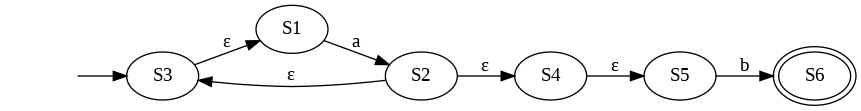

In [17]:
from IPython.display import Image
visualize_NFA(nfa)
Image(filename='NFA.png')